In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import glob

# ETL PROCEDURE

In [13]:
def estrazione_igrometri(lista_stanze:list, source:str):
    """Funzione che cicla sopra i file in cartella contenente csv ottenuti da igrometri, estrae i dati, concatena i dataframe, 
    modifica nomi e ordine colonne ed esporta un csv."""
    
    now=datetime.now().strftime('%Y%m%d_%H-%M-%S')
    log_file=f"./log_files/{now} - log_file.txt"
    def log(message):
        "Semplice funzione di log"
        with open (log_file,"a") as log:
            log.write(f"{now}: {message}\n")

    log("Creo df_igrometri") 
    df_igrometri=pd.DataFrame()
    
    #ESTRAZIONE DATI
    for n in lista_stanze:
        log(f"Cerco stanza {n}")
        df=pd.DataFrame()
        for file in glob.glob(f"{source}*{n}*.csv"):
            df_temperatura=pd.read_csv(file)
            log(f"df temperatura {n}: {df_temperatura.shape}")

            #TRASFORMAZIONE DATI
            #Inizio condizione particolare utilizzata per i primi csv estratti che erano in formato diverso.
            if df_temperatura.columns[0]=="Date":
                df_temperatura.rename(columns={'Date': 'data','Temp': 'temperatura','Umidità': 'umidita','Remark': 'note'}, inplace=True)
            if df_temperatura.columns[0]=="time":
                df_temperatura.rename(columns={'time': 'data','temperature': 'temperatura','humidity': 'umidita','note': 'note'}, inplace=True)
            #Fine condizione particolare
            df=pd.concat([df,df_temperatura],ignore_index=True).drop_duplicates("data",ignore_index=True)

            df.drop(columns=["note"], inplace=True)
            if n=="camera_agne":
                n="camera_2" 
                print("n è diventato Camera_2")
            df["stanza"]=n
            
            log(f"df stanza {n}: {df_temperatura.shape}")
        
        df_igrometri=pd.concat([df_igrometri,df],ignore_index=True)
        df_igrometri.drop(columns=["Unnamed: 4"], inplace=True, errors="ignore")
        log(f"df_igrometri: {df_igrometri.shape}")

    #TRASFORMAZIONE DATI
    # Modifica dtypes delle colonne
    df_igrometri["temperatura"]=df_igrometri["temperatura"].str.replace("℃","")
    df_igrometri["umidita"]=df_igrometri["umidita"].str.replace("%","")
    df_igrometri["stanza"]=df_igrometri["stanza"].astype(str)
    df_igrometri["temperatura"]=df_igrometri["temperatura"].astype(float)
    df_igrometri["umidita"]=df_igrometri["umidita"].astype(float)
    df_igrometri["data"]=pd.to_datetime(df_igrometri["data"])
    
    #LOAD
    df_igrometri.to_csv("igrometri.csv", columns=["data","stanza","temperatura","umidita"], index=False)
    log(f"Esportazione csv.")
    df_igrometri.sort_values(by=["data"], inplace=True)
    return df_igrometri

In [14]:
lista_stanze=["Soggiorno", "Cucina", "Balcone_est", "Balcone_nord", "Bagno", "Camera_2", "camera_agne"]
source_folder="./sensor/"

df_igrometri=estrazione_igrometri(lista_stanze, source_folder)

n è diventato Camera_2


In [15]:
df_igrometri.loc[df_igrometri["stanza"]=="Camera_2"].sort_values(by="data")

,data,temperatura,umidita,stanza
195098,2023-09-18 11:03:56,24.31,70.00,Camera_2
195099,2023-09-18 11:13:56,24.31,70.00,Camera_2
195100,2023-09-18 11:23:56,24.31,70.00,Camera_2
195101,2023-09-18 11:33:56,24.31,70.00,Camera_2
195102,2023-09-18 11:43:56,24.31,70.00,Camera_2
...,...,...,...,...
208923,2023-12-23 11:13:56,20.81,51.75,Camera_2
208924,2023-12-23 11:23:56,20.88,51.38,Camera_2
208925,2023-12-23 11:33:56,20.81,50.44,Camera_2
208926,2023-12-23 11:43:56,20.75,50.06,Camera_2


# GRAFICI

## Andamento temperatura delle differenti stanze

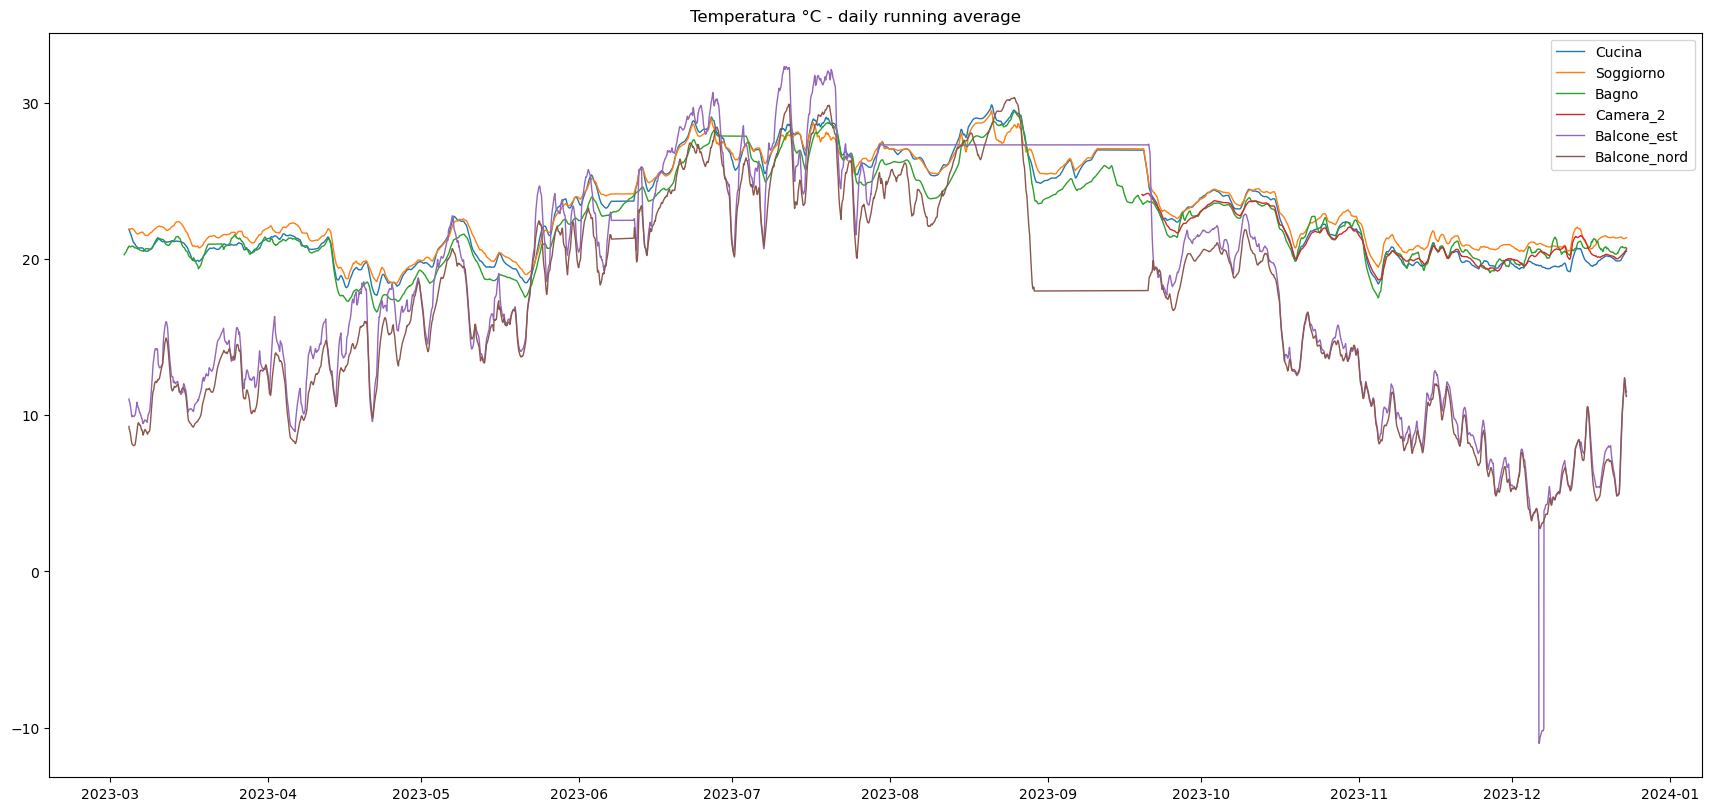

In [16]:
fig, ax=plt.subplots(figsize=(17,8), layout="constrained")
fig.suptitle('Temperatura °C - daily running average')

ax.plot(df_igrometri[df_igrometri["stanza"]=="Cucina"].data, df_igrometri[df_igrometri["stanza"]=="Cucina"].temperatura.rolling(window=144).mean(),label='Cucina', linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Soggiorno"].data, df_igrometri[df_igrometri["stanza"]=="Soggiorno"].temperatura.rolling(window=144).mean(),label='Soggiorno',linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Bagno"].data, df_igrometri[df_igrometri["stanza"]=="Bagno"].temperatura.rolling(window=144).mean(),label='Bagno',linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Camera_2"].data, df_igrometri[df_igrometri["stanza"]=="Camera_2"].temperatura.rolling(window=144).mean(),label='Camera_2',linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Balcone_est"].data, df_igrometri[df_igrometri["stanza"]=="Balcone_est"].temperatura.rolling(window=144).mean(),label='Balcone_est',linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Balcone_nord"].data, df_igrometri[df_igrometri["stanza"]=="Balcone_nord"].temperatura.rolling(window=144).mean(), label='Balcone_nord',linewidth=1)
plt.legend()
plt.savefig("./grafici/Temperatura °C - daily running average.jpg")
plt.show()

## Andamento percentuale di umidita sovrapposto delle differenti stanze

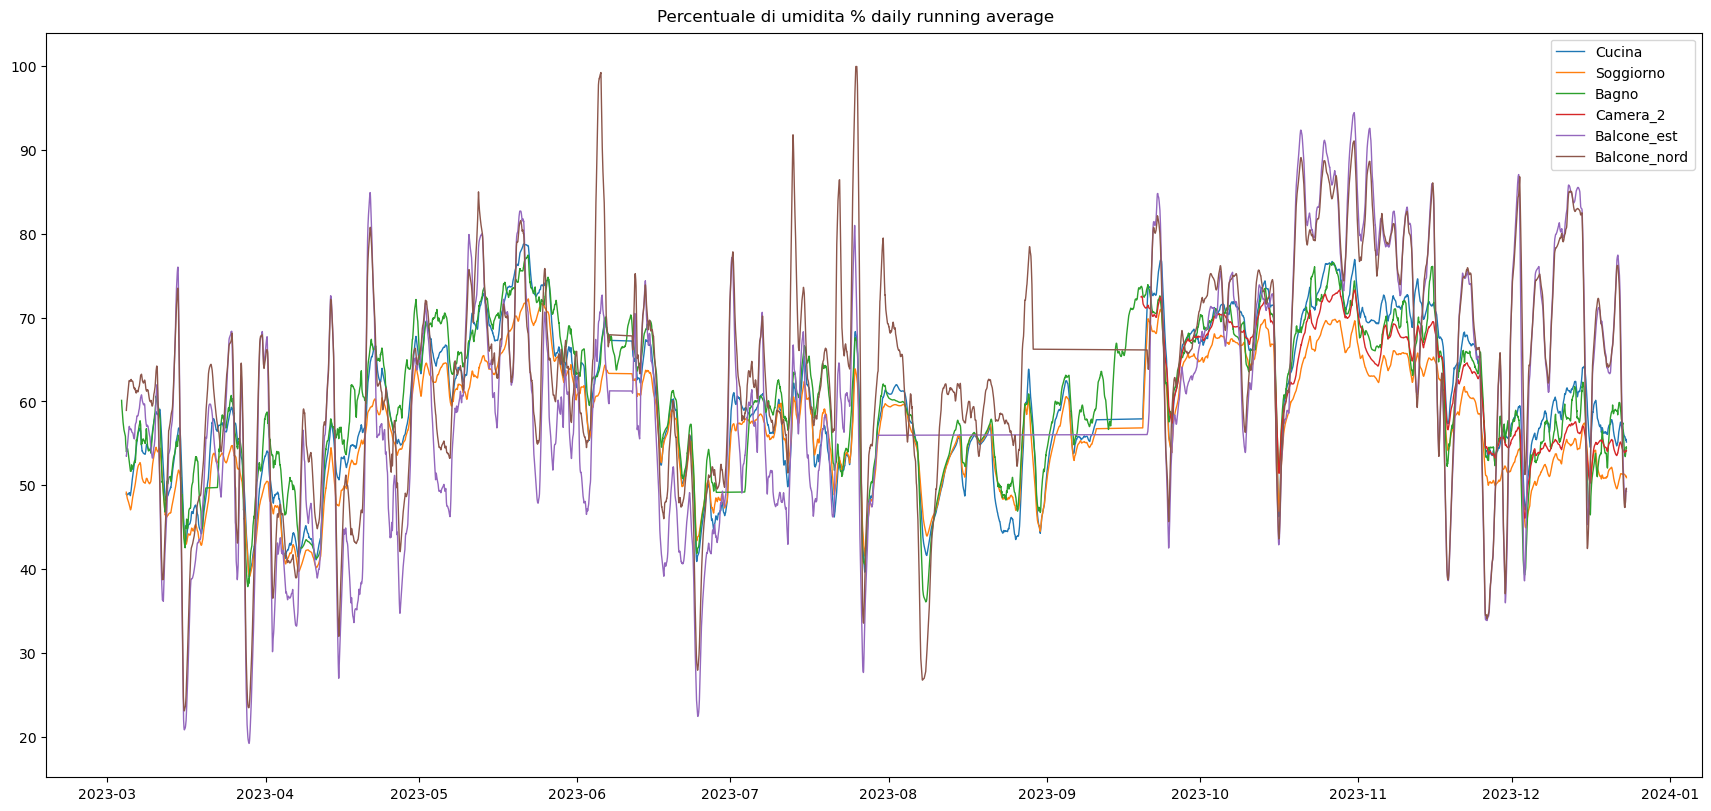

In [17]:
fig, ax=plt.subplots(figsize=(17,8), layout="constrained")
fig.suptitle('Percentuale di umidita % daily running average')

ax.plot(df_igrometri[df_igrometri["stanza"]=="Cucina"].data, df_igrometri[df_igrometri["stanza"]=="Cucina"].umidita.rolling(window=144).mean(),label='Cucina',linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Soggiorno"].data, df_igrometri[df_igrometri["stanza"]=="Soggiorno"].umidita.rolling(window=144).mean(),label='Soggiorno',linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Bagno"].data, df_igrometri[df_igrometri["stanza"]=="Bagno"].umidita.rolling(window=144).mean(),label='Bagno',linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Camera_2"].data, df_igrometri[df_igrometri["stanza"]=="Camera_2"].umidita.rolling(window=144).mean(),label='Camera_2',linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Balcone_est"].data, df_igrometri[df_igrometri["stanza"]=="Balcone_est"].umidita.rolling(window=144).mean(),label='Balcone_est',linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Balcone_nord"].data, df_igrometri[df_igrometri["stanza"]=="Balcone_nord"].umidita.rolling(window=144).mean(),label='Balcone_nord',linewidth=1)
plt.legend()
plt.savefig("./grafici/Percentuale di umidita % daily running average.jpg")
plt.show()

## Andamento delle temperature
Multipli grafici per l'andamento delle temperature nelle singole stanze

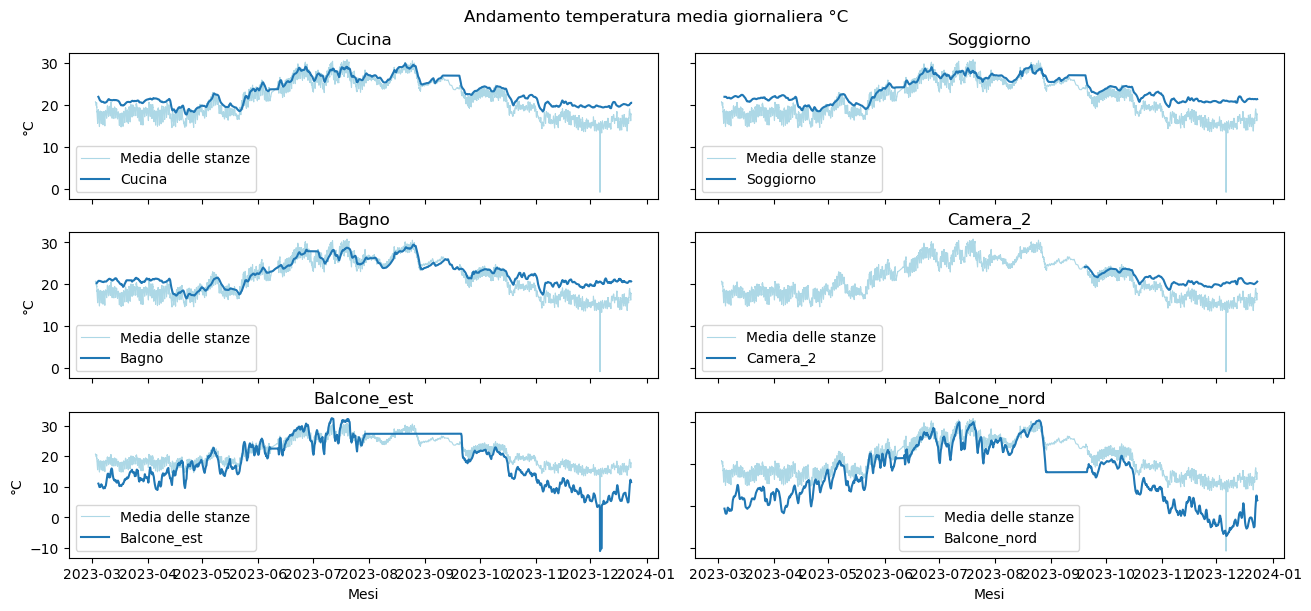

In [18]:
fig, axs=plt.subplots(3,2, layout="constrained",figsize=(13,6))
fig.suptitle('Andamento temperatura media giornaliera °C')

axs[0,0].plot(df_igrometri.data, df_igrometri.temperatura.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[0,0].plot(df_igrometri[df_igrometri["stanza"]=="Cucina"].data, df_igrometri[df_igrometri["stanza"]=="Cucina"].temperatura.rolling(window=144).mean(), label="Cucina")
axs[0,0].legend()
axs[0,0].set_title('Cucina')

axs[0,1].plot(df_igrometri.data, df_igrometri.temperatura.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[0,1].plot(df_igrometri[df_igrometri["stanza"]=="Soggiorno"].data, df_igrometri[df_igrometri["stanza"]=="Soggiorno"].temperatura.rolling(window=144).mean(), label="Soggiorno")
axs[0,1].legend()
axs[0,1].set_title('Soggiorno')

axs[1,0].plot(df_igrometri.data, df_igrometri.temperatura.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[1,0].plot(df_igrometri[df_igrometri["stanza"]=="Bagno"].data, df_igrometri[df_igrometri["stanza"]=="Bagno"].temperatura.rolling(window=144).mean(), label="Bagno")
axs[1,0].legend()
axs[1,0].set_title('Bagno')

axs[1,1].plot(df_igrometri.data, df_igrometri.temperatura.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[1,1].plot(df_igrometri[df_igrometri["stanza"]=="Camera_2"].data, df_igrometri[df_igrometri["stanza"]=="Camera_2"].temperatura.rolling(window=144).mean(), label="Camera_2")
axs[1,1].legend()
axs[1,1].set_title('Camera_2')

axs[2,0].plot(df_igrometri.data, df_igrometri.temperatura.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[2,0].plot(df_igrometri[df_igrometri["stanza"]=="Balcone_est"].data, df_igrometri[df_igrometri["stanza"]=="Balcone_est"].temperatura.rolling(window=144).mean(), label="Balcone_est")
axs[2,0].legend()
axs[2,0].set_title('Balcone_est')

axs[2,1].plot(df_igrometri.data, df_igrometri.temperatura.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[2,1].plot(df_igrometri[df_igrometri["stanza"]=="Balcone_nord"].data, df_igrometri[df_igrometri["stanza"]=="Balcone_nord"].temperatura.rolling(window=144).mean(), label="Balcone_nord")
axs[2,1].legend()
axs[2,1].set_title('Balcone_nord')

for ax in axs.flat:
    ax.set(xlabel='Mesi', ylabel='°C')

for ax in axs.flat:
    ax.label_outer()
plt.savefig("./grafici/Andamento temperatura media giornaliera °C.jpg")
plt.show()

## Andamento della percentuale di umidita
Multipli grafici per l'andamento della percentuale di umidita nelle singole stanze

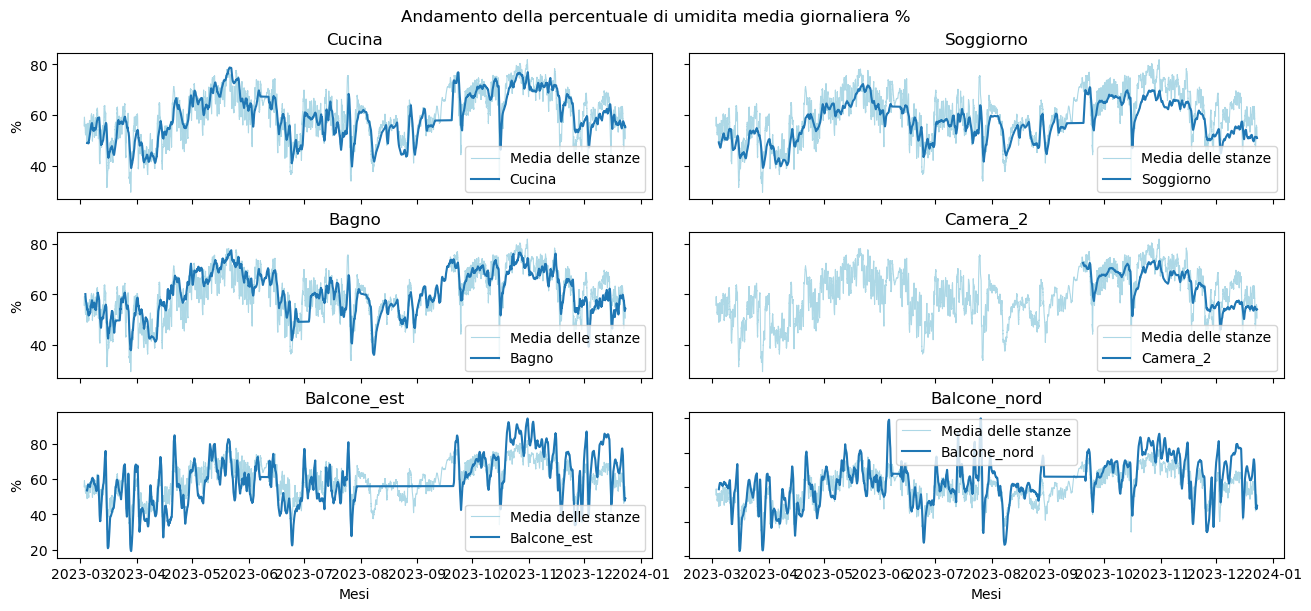

In [19]:
fig, axs=plt.subplots(3,2, layout="constrained",figsize=(13,6))
fig.suptitle('Andamento della percentuale di umidita media giornaliera %')

axs[0,0].plot(df_igrometri.data, df_igrometri.umidita.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[0,0].plot(df_igrometri[df_igrometri["stanza"]=="Cucina"].data, df_igrometri[df_igrometri["stanza"]=="Cucina"].umidita.rolling(window=144).mean(),label="Cucina")
axs[0,0].legend()
axs[0,0].set_title('Cucina')

axs[0,1].plot(df_igrometri.data, df_igrometri.umidita.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[0,1].plot(df_igrometri[df_igrometri["stanza"]=="Soggiorno"].data, df_igrometri[df_igrometri["stanza"]=="Soggiorno"].umidita.rolling(window=144).mean(), label="Soggiorno")
axs[0,1].legend()
axs[0,1].set_title('Soggiorno')

axs[1,0].plot(df_igrometri.data, df_igrometri.umidita.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[1,0].plot(df_igrometri[df_igrometri["stanza"]=="Bagno"].data, df_igrometri[df_igrometri["stanza"]=="Bagno"].umidita.rolling(window=144).mean(),label="Bagno")
axs[1,0].legend()
axs[1,0].set_title('Bagno')

axs[1,1].plot(df_igrometri.data, df_igrometri.umidita.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[1,1].plot(df_igrometri[df_igrometri["stanza"]=="Camera_2"].data, df_igrometri[df_igrometri["stanza"]=="Camera_2"].umidita.rolling(window=144).mean(),label="Camera_2")
axs[1,1].legend()
axs[1,1].set_title('Camera_2')

axs[2,0].plot(df_igrometri.data, df_igrometri.umidita.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[2,0].plot(df_igrometri[df_igrometri["stanza"]=="Balcone_est"].data, df_igrometri[df_igrometri["stanza"]=="Balcone_est"].umidita.rolling(window=144).mean(),label="Balcone_est")
axs[2,0].legend()
axs[2,0].set_title('Balcone_est')

axs[2,1].plot(df_igrometri.data, df_igrometri.umidita.rolling(window=144).mean(), linewidth=.8, color="lightblue", label="Media delle stanze")
axs[2,1].plot(df_igrometri[df_igrometri["stanza"]=="Balcone_nord"].data, df_igrometri[df_igrometri["stanza"]=="Balcone_nord"].umidita.rolling(window=144).mean(),label="Balcone_nord")
axs[2,1].legend()
axs[2,1].set_title('Balcone_nord')

for ax in axs.flat:
    ax.set(xlabel='Mesi', ylabel='%')

for ax in axs.flat:
    ax.label_outer()
plt.savefig("./grafici/Andamento della percentuale di umidita media giornaliera %.jpg")
plt.show()

## Andamento temperatura soggiorno e balcone

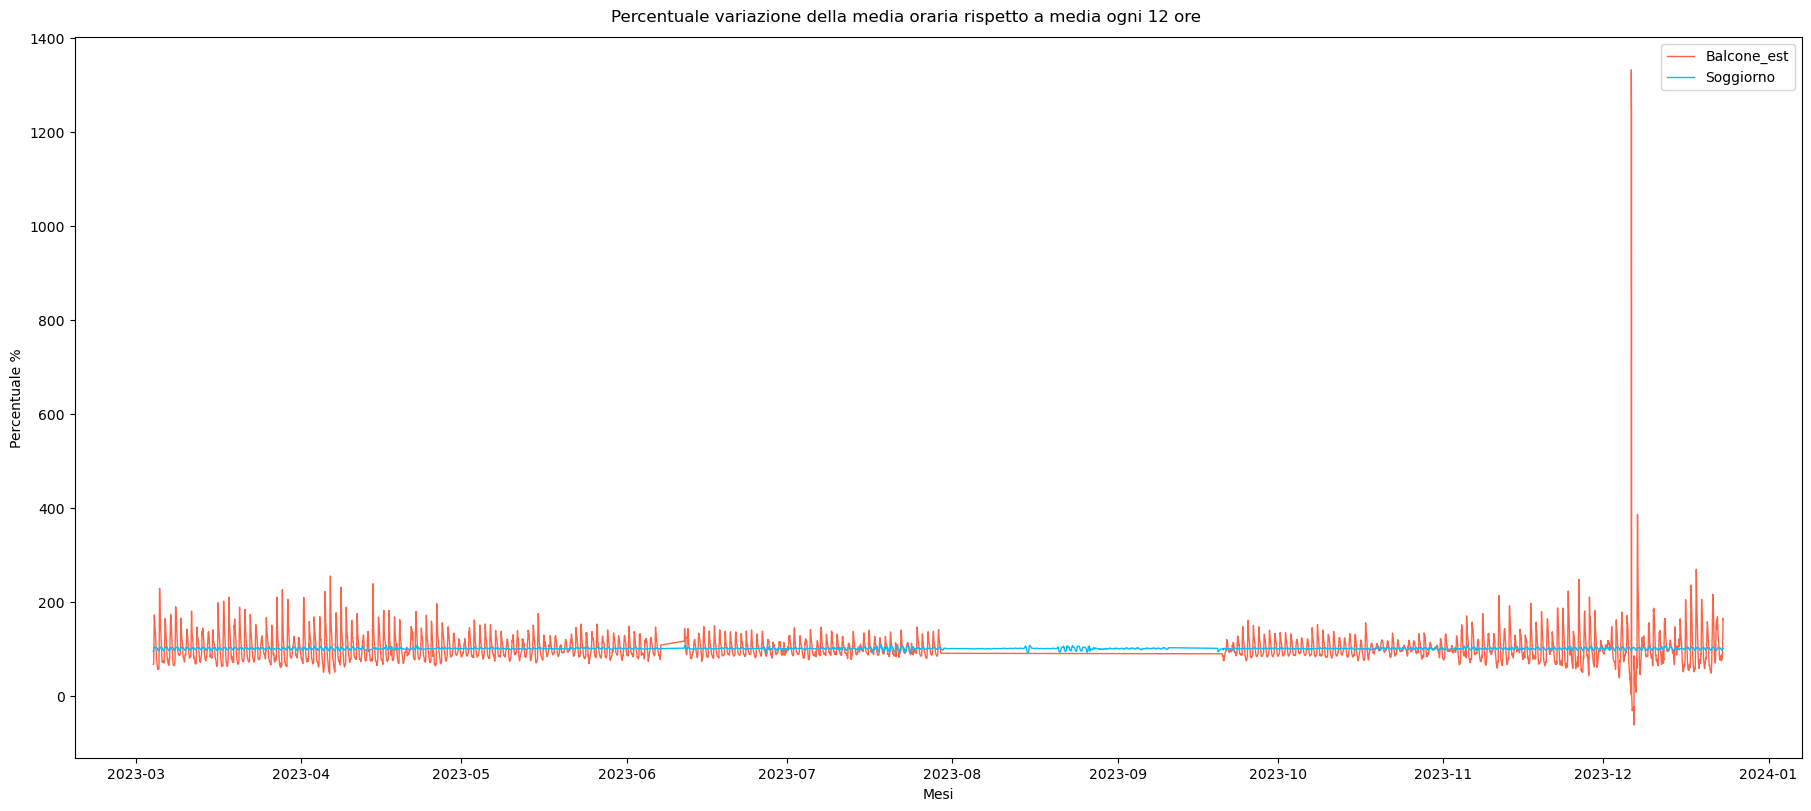

In [20]:
fig, ax=plt.subplots(figsize=(18,8), layout="constrained")
fig.suptitle('Percentuale variazione della media oraria rispetto a media ogni 12 ore')
ax.plot(df_igrometri[df_igrometri["stanza"]=="Balcone_est"].data,
        df_igrometri[df_igrometri["stanza"]=="Balcone_est"].temperatura.rolling(window=6).mean()/df_igrometri[df_igrometri["stanza"]=="Balcone_est"].temperatura.rolling(window=72).mean()*100,
        label="Balcone_est", linewidth=1,color="tomato")
ax.plot(df_igrometri[df_igrometri["stanza"]=="Soggiorno"].data,
        df_igrometri[df_igrometri["stanza"]=="Soggiorno"].temperatura.rolling(window=6).mean()/df_igrometri[df_igrometri["stanza"]=="Soggiorno"].temperatura.rolling(window=72).mean()*100,
        label="Soggiorno", linewidth=1,color="deepskyblue")
ax.set(xlabel='Mesi', ylabel='Percentuale %')
plt.legend()
plt.savefig("./grafici/Percentuale variazione della media oraria rispetto a media ogni 12 ore.jpg")
plt.show()

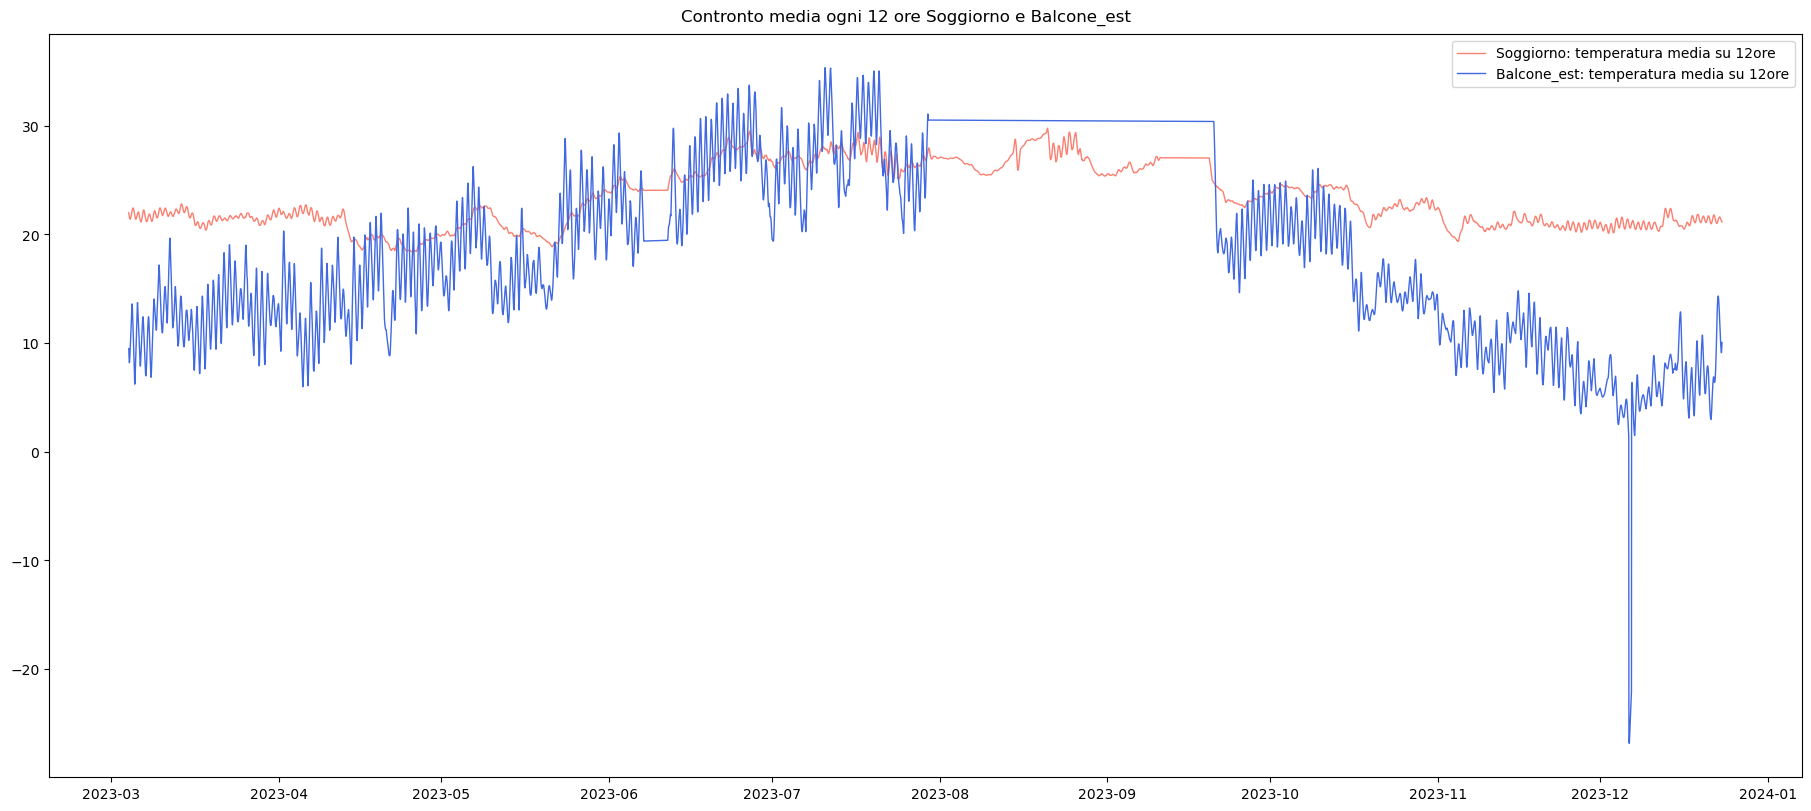

In [21]:
fig, ax=plt.subplots(figsize=(18,8), layout="constrained")
fig.suptitle('Contronto media ogni 12 ore Soggiorno e Balcone_est')

ax.plot(df_igrometri[df_igrometri["stanza"]=="Soggiorno"].data, df_igrometri[df_igrometri["stanza"]=="Soggiorno"].temperatura.rolling(window=72).mean(),
        label="Soggiorno: temperatura media su 12ore", linewidth=1,color="salmon")
ax.plot(df_igrometri[df_igrometri["stanza"]=="Balcone_est"].data, df_igrometri[df_igrometri["stanza"]=="Balcone_est"].temperatura.rolling(window=72).mean(),
        label="Balcone_est: temperatura media su 12ore", linewidth=1,color="royalblue")
plt.legend()
plt.savefig("./grafici/Contronto media ogni 12 ore Soggiorno e Balcone_est.jpg")
plt.show()

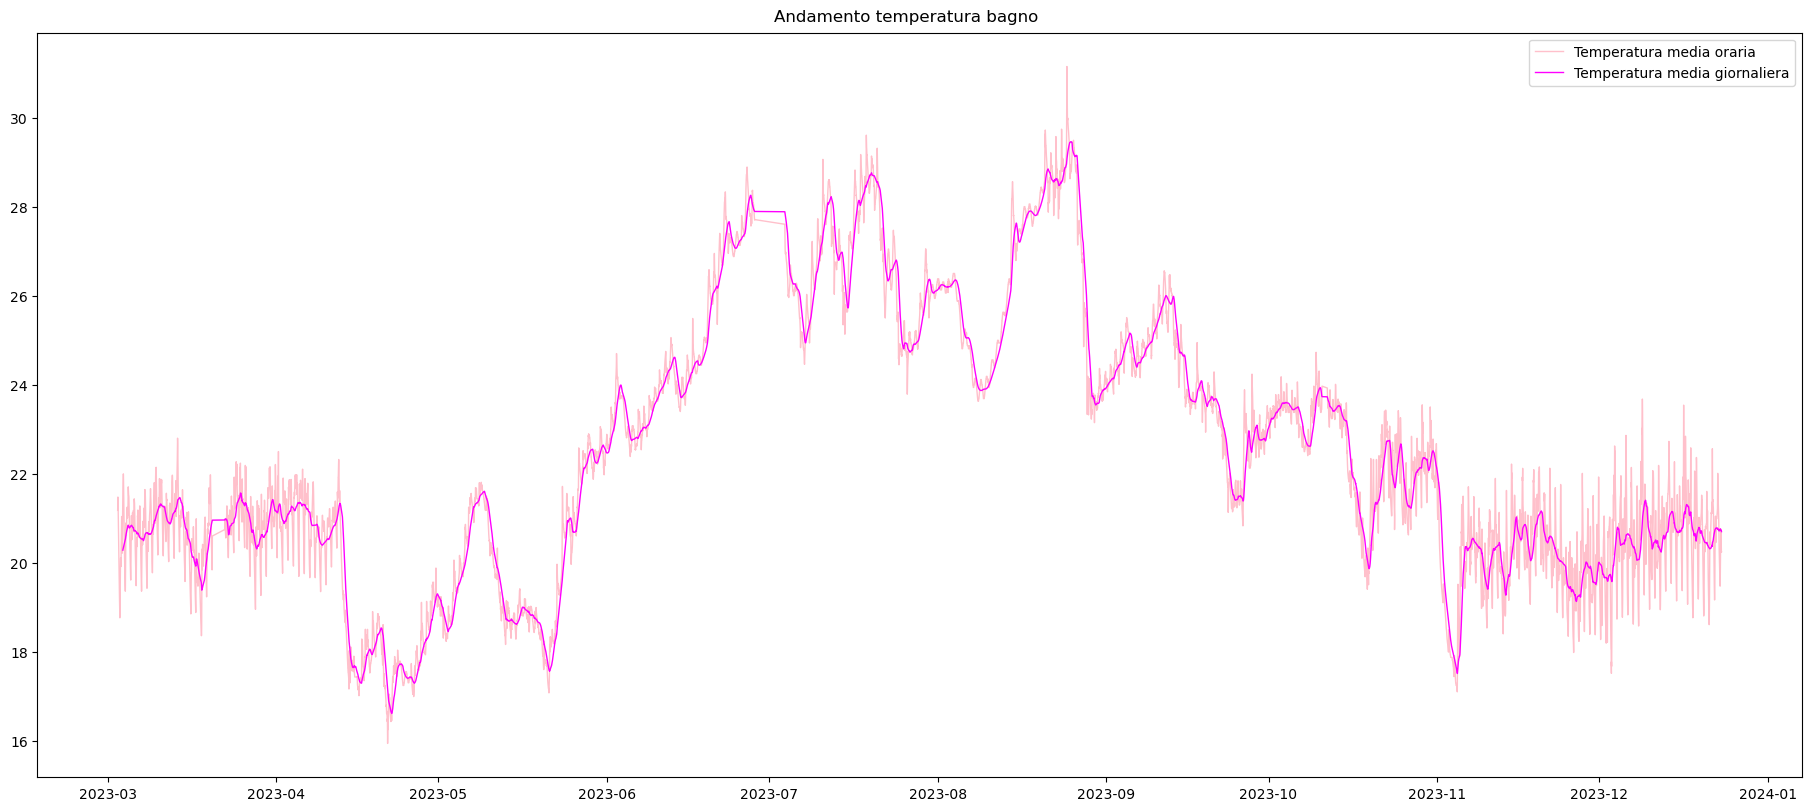

In [22]:
fig, ax=plt.subplots(figsize=(18,8), layout="constrained")
fig.suptitle('Andamento temperatura bagno')

ax.plot(df_igrometri[df_igrometri["stanza"]=="Bagno"].data, df_igrometri[df_igrometri["stanza"]=="Bagno"].temperatura.rolling(window=6).mean(),
        label="Temperatura media oraria", color="pink", linewidth=1)
ax.plot(df_igrometri[df_igrometri["stanza"]=="Bagno"].data, df_igrometri[df_igrometri["stanza"]=="Bagno"].temperatura.rolling(window=144).mean(),
        label="Temperatura media giornaliera",color="magenta", linewidth=1)
plt.legend()
plt.savefig("./grafici/Andamento temperatura bagno.jpg")
plt.show()